In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.seasonal import STL

sns.set_theme(style="ticks", palette="mako")
warnings.filterwarnings("ignore")

### Master DataFrame

In [2]:
master_df = pd.read_csv("data/2016_2021_master_df.csv")
master_df["DATE_PST"] = pd.to_datetime(master_df["DATE_PST"])
master_df.set_index("DATE_PST", inplace=True)
display(master_df.head())
print(master_df.shape)

,Vancouver_Clark_Drive_PM25,Vancouver_International_Airport_#2_PM25,North_Vancouver_Mahon_Park_PM25,North_Vancouver_Second_Narrows_PM25
DATE_PST,,,,
2016-01-01 01:00:00,30.557,22.71692,22.798870,NaN
2016-01-01 02:00:00,34.661,21.95020,22.909090,6.341111
2016-01-01 03:00:00,35.419,21.25953,19.857730,5.340278
2016-01-01 04:00:00,24.335,19.93333,13.575990,3.907917
2016-01-01 05:00:00,29.336,19.07922,7.079589,7.235889


(57014, 4)


### Candidate Subset Selection

(9503, 4)


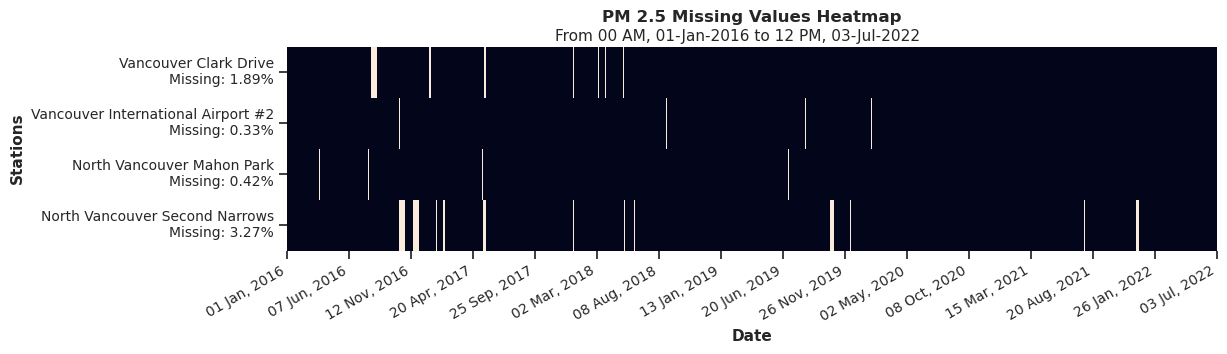

In [3]:
# Resampled data to 6h aggregate
from tshelpers.plot import plot_missing

master_df_6h = master_df.resample('6H').mean()
print(master_df_6h.shape)
plot_missing(master_df_6h)

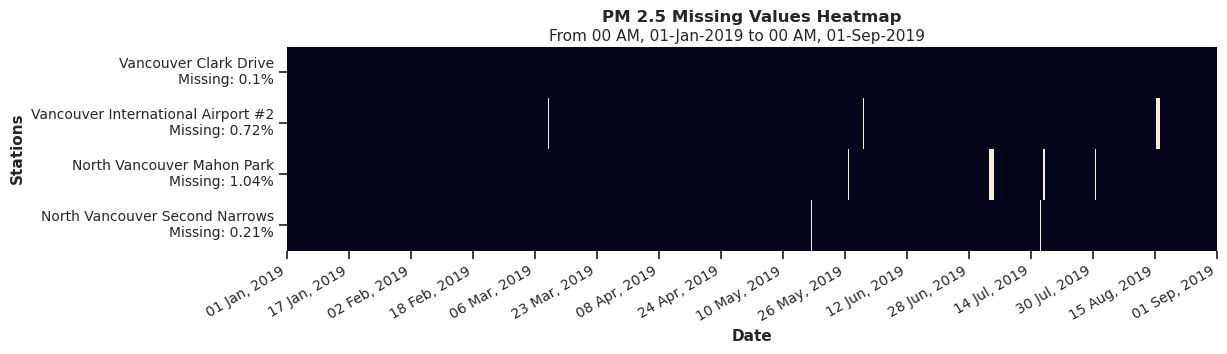

In [4]:
# Candidate subsample on Jan 2019 to Sept 2019
plot_missing(master_df_6h,
             start=datetime(2019, 1, 1),
             end=datetime(2019, 9, 1))

### Season-Trend Decomposition with LOESS

In [5]:
# Stations
master_df_6h.columns

Index(['Vancouver_Clark_Drive_PM25', 'Vancouver_International_Airport_#2_PM25',
       'North_Vancouver_Mahon_Park_PM25',
       'North_Vancouver_Second_Narrows_PM25'],
      dtype='object')

In [6]:
from tshelpers.metrics import stationarity_test

# Subset
subset = master_df_6h[datetime(2020, 1, 1): datetime(2020, 9, 1)]

# Decompositions
decompositions = {}
for station in subset.columns:
    decompositions[station] = {}
    # Stationarity tests on observed data
    decompositions[station]["Stationarity_Observed"] = stationarity_test(subset, station)
    # STL Decomposition
    decomposed = STL(
        subset[station].interpolate(),
        seasonal=7,
        robust=True
    ).fit()
    decompositions[station]["Decomposition"] = pd.concat([
        decomposed.observed, decomposed.trend, decomposed.seasonal, decomposed.resid
        ], axis=1)
    # Stationarity tests on trend, season, and residuals
    decompositions[station]["Stationarity_Trend"] = stationarity_test(decompositions[station]["Decomposition"], "trend")
    decompositions[station]["Stationarity_Seasonal"] = stationarity_test(decompositions[station]["Decomposition"], "season")
    decompositions[station]["Stationarity_Residuals"] = stationarity_test(decompositions[station]["Decomposition"], "resid")

In [7]:
decompositions["Vancouver_Clark_Drive_PM25"].keys()

dict_keys(['Stationarity_Observed', 'Decomposition', 'Stationarity_Trend', 'Stationarity_Seasonal', 'Stationarity_Residuals'])

Testing for stationarity on subsets

In [8]:
# Stationarity on Observed Data
for station in subset.columns:
    print(f"{station}:")
    display(decompositions[station]["Stationarity_Observed"])

Vancouver_Clark_Drive_PM25:


,adf,kpss
Test Statistic,-6.2176,0.2156
p-value,0.0,0.1
Lags Used,13,16
Decision,Stationary,Stationary


Vancouver_International_Airport_#2_PM25:


,adf,kpss
Test Statistic,-5.8469,0.5834
p-value,0.0,0.0241
Lags Used,16,17
Decision,Stationary,Non-Stationary


North_Vancouver_Mahon_Park_PM25:


,adf,kpss
Test Statistic,-6.185,0.497
p-value,0.0,0.0424
Lags Used,12,17
Decision,Stationary,Non-Stationary


North_Vancouver_Second_Narrows_PM25:


,adf,kpss
Test Statistic,-4.4734,1.7295
p-value,0.0002,0.01
Lags Used,20,17
Decision,Stationary,Non-Stationary


In [9]:
# Stationarity on Trend
for station in subset.columns:
    print(f"{station}:")
    display(decompositions[station]["Stationarity_Trend"])

Vancouver_Clark_Drive_PM25:


,adf,kpss
Test Statistic,-4.7081,0.229
p-value,0.0001,0.1
Lags Used,22,19
Decision,Stationary,Stationary


Vancouver_International_Airport_#2_PM25:


,adf,kpss
Test Statistic,-2.7119,1.1062
p-value,0.072,0.01
Lags Used,12,19
Decision,Non-Stationary,Non-Stationary


North_Vancouver_Mahon_Park_PM25:


,adf,kpss
Test Statistic,-3.4268,1.2865
p-value,0.0101,0.01
Lags Used,22,19
Decision,Stationary,Non-Stationary


North_Vancouver_Second_Narrows_PM25:


,adf,kpss
Test Statistic,-2.716,2.3223
p-value,0.0713,0.01
Lags Used,22,19
Decision,Non-Stationary,Non-Stationary


In [10]:
# Stationarity on Residuals
for station in subset.columns:
    print(f"{station}:")
    display(decompositions[station]["Stationarity_Residuals"])

Vancouver_Clark_Drive_PM25:


,adf,kpss
Test Statistic,-8.401,0.1801
p-value,0.0,0.1
Lags Used,22,12
Decision,Stationary,Stationary


Vancouver_International_Airport_#2_PM25:


,adf,kpss
Test Statistic,-8.4911,0.023
p-value,0.0,0.1
Lags Used,10,15
Decision,Stationary,Stationary


North_Vancouver_Mahon_Park_PM25:


,adf,kpss
Test Statistic,-8.1927,0.0852
p-value,0.0,0.1
Lags Used,22,14
Decision,Stationary,Stationary


North_Vancouver_Second_Narrows_PM25:


,adf,kpss
Test Statistic,-12.1868,0.073
p-value,0.0,0.1
Lags Used,4,12
Decision,Stationary,Stationary


Seasonal Decomposition Plots on Vancouver Clark Drive (stationary)

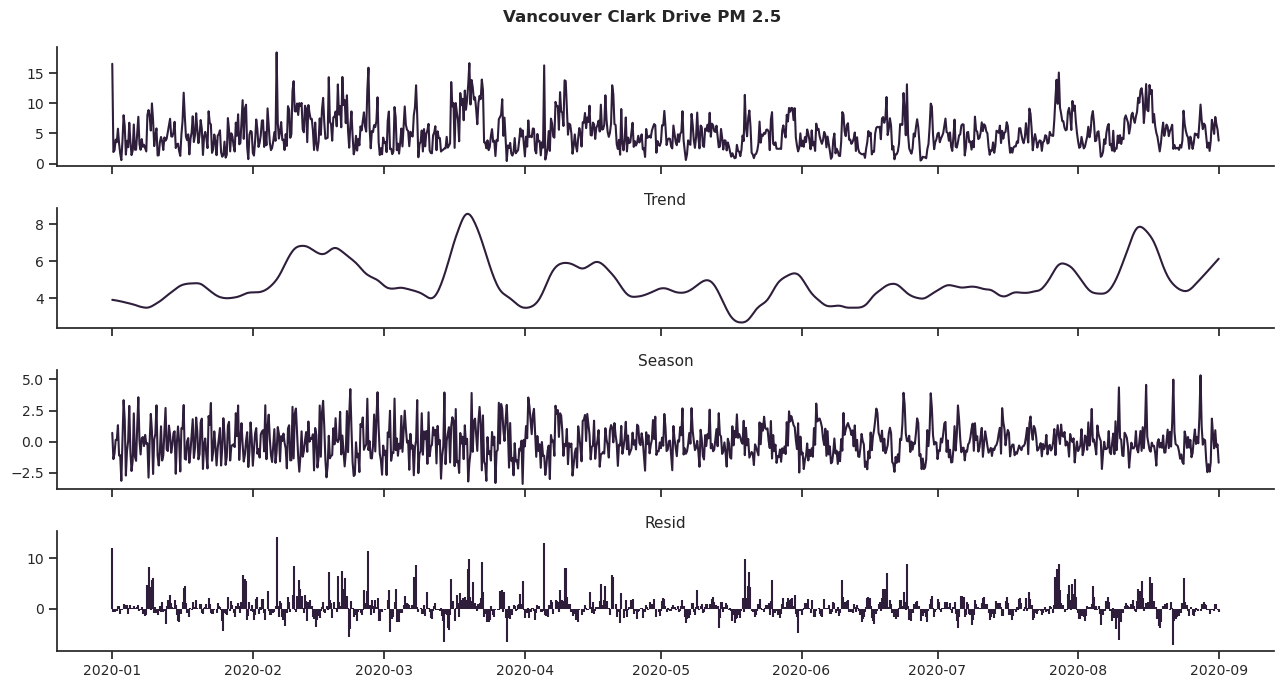

In [11]:
# Seasonal Decomposition Plots
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(13, 7))

for i, column in enumerate(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"].columns):
    if column == "resid":
        _, stls, _ = ax[i].stem(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"][column].index,
                   decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"][column],
                   markerfmt=' ',
                   basefmt=' ')
        plt.setp(stls, 'linewidth', 1.5)
    else:
        ax[i].plot(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"][column])
    ax[i].set_title(column.capitalize(), y=0.96, fontsize=11)
    ax[i].tick_params(labelsize=10)
ax[0].set_title("")
plt.suptitle("Vancouver Clark Drive PM 2.5", fontsize=12, fontweight="bold")
sns.despine()
plt.tight_layout()

In [12]:
# Testing for stationarity on trend, season, and residuals
print("Trend:")
display(stationarity_test(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"], value="trend"))
print("Seasonal:")
display(stationarity_test(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"], value="season"))
print("Residuals:")
display(stationarity_test(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"], value="resid"))

Trend:


,adf,kpss
Test Statistic,-4.7081,0.229
p-value,0.0001,0.1
Lags Used,22,19
Decision,Stationary,Stationary


Seasonal:


,adf,kpss
Test Statistic,-27.4493,0.0055
p-value,0.0,0.1
Lags Used,22,12
Decision,Stationary,Stationary


Residuals:


,adf,kpss
Test Statistic,-8.401,0.1801
p-value,0.0,0.1
Lags Used,22,12
Decision,Stationary,Stationary


Checking for Partial Autocorrelation and Autocorrelation on trend, season, and residuals

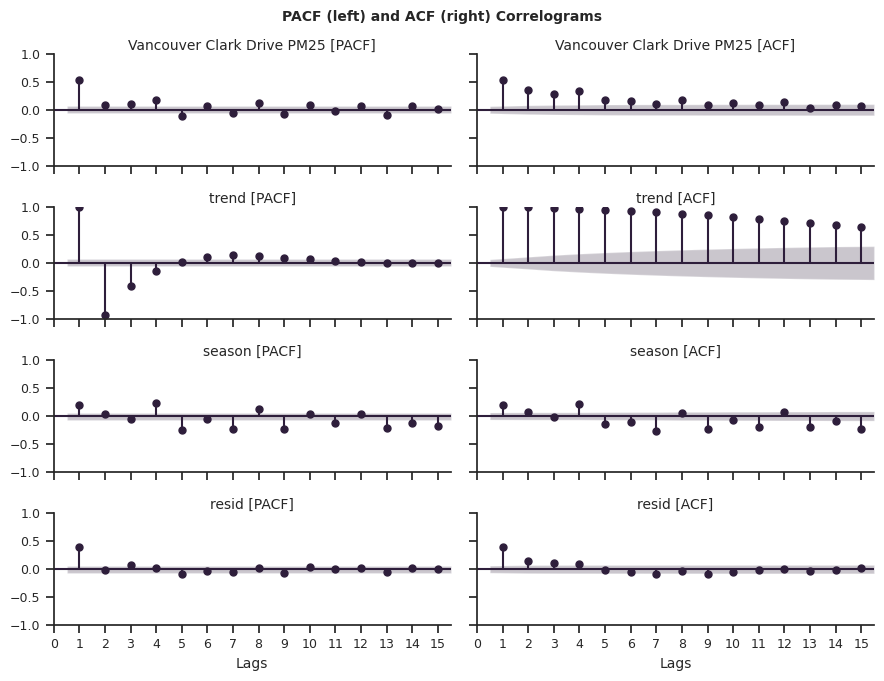

In [13]:
# Investigate residuals for autocorrelation
from tshelpers.plot import plot_multiple_pacf

plot_multiple_pacf(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"],
                   decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"].columns,
                   figsize=(9,7))

Seasonal Decomposition Plots on Vancouver International Airport (non-stationary)

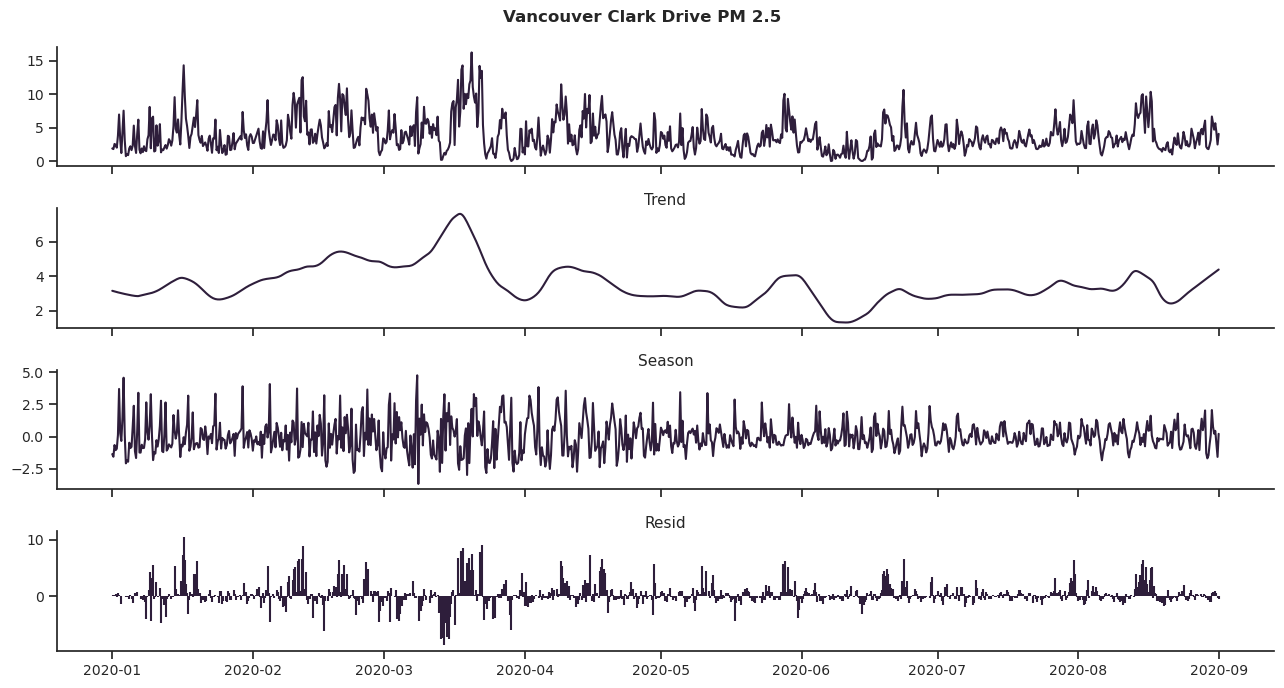

In [14]:
# Seasonal Decomposition Plots
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(13, 7))

for i, column in enumerate(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"].columns):
    if column == "resid":
        _, stls, _ = ax[i].stem(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"][column].index,
                   decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"][column],
                   markerfmt=' ',
                   basefmt=' ')
        plt.setp(stls, 'linewidth', 1.5)
    else:
        ax[i].plot(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"][column])
    ax[i].set_title(column.capitalize(), y=0.96, fontsize=11)
    ax[i].tick_params(labelsize=10)
ax[0].set_title("")
plt.suptitle("Vancouver Clark Drive PM 2.5", fontsize=12, fontweight="bold")
sns.despine()
plt.tight_layout()

In [15]:
# Testing for stationarity on trend, season, and residuals
print("Trend:")
display(stationarity_test(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"], value="trend"))
print("Seasonal:")
display(stationarity_test(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"], value="season"))
print("Residuals:")
display(stationarity_test(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"], value="resid"))

Trend:


,adf,kpss
Test Statistic,-2.7119,1.1062
p-value,0.072,0.01
Lags Used,12,19
Decision,Non-Stationary,Non-Stationary


Seasonal:


,adf,kpss
Test Statistic,-38.026,0.0043
p-value,0.0,0.1
Lags Used,22,11
Decision,Stationary,Stationary


Residuals:


,adf,kpss
Test Statistic,-8.4911,0.023
p-value,0.0,0.1
Lags Used,10,15
Decision,Stationary,Stationary


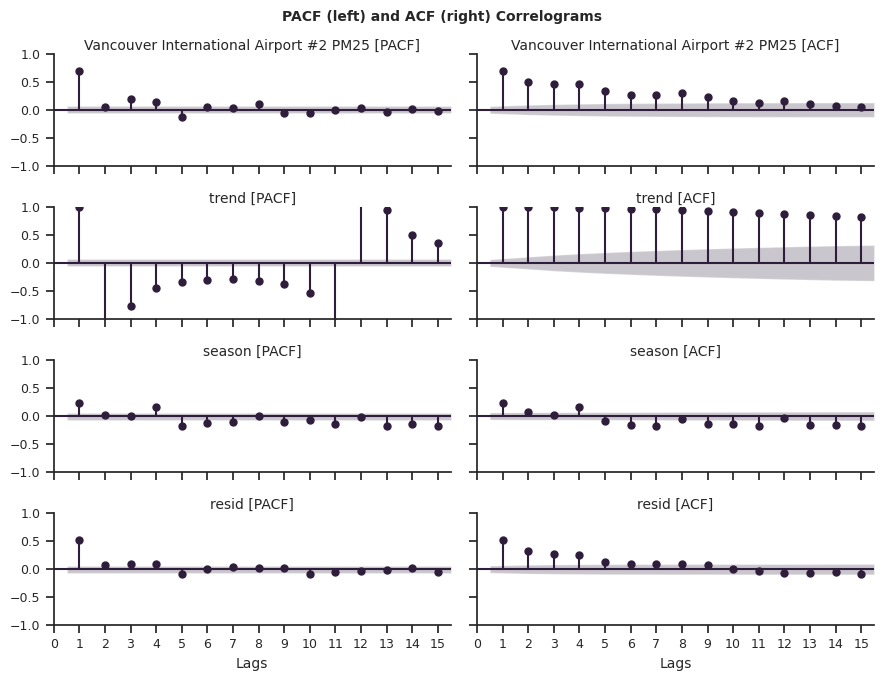

In [16]:
# Investigate residuals for autocorrelation
plot_multiple_pacf(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"],
                   decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"].columns,
                   figsize=(9,7))

### Similarity on Decomposed Trends

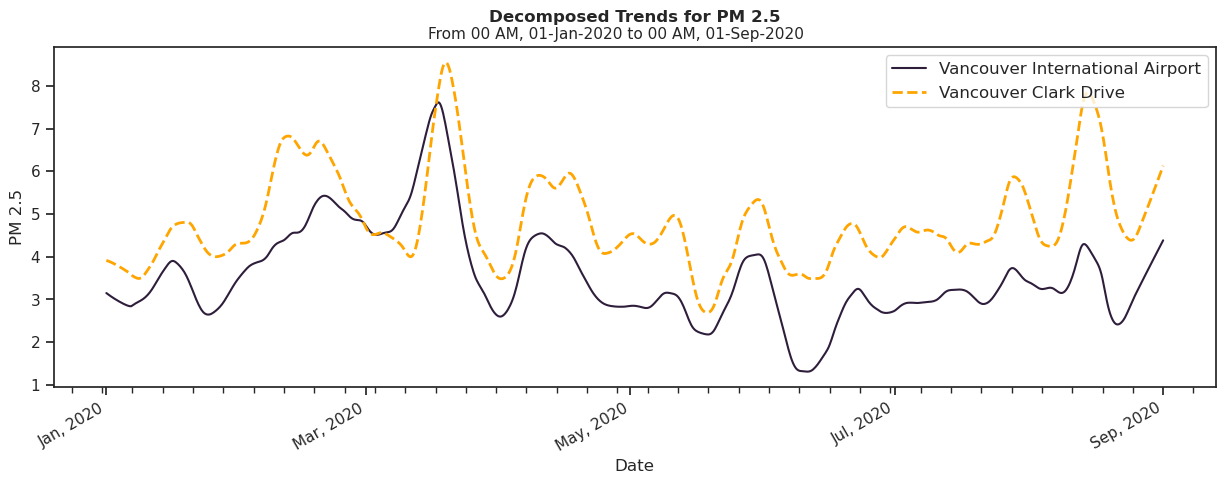

In [17]:
from tshelpers.plot import plot_compare

plot_compare(pd.DataFrame(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"]["trend"]),
             pd.DataFrame(decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"]["trend"]),
             value="trend",
             value_missing="trend",
             missing_only=False,
             fill=False,
             plot_title=f"Decomposed Trends for PM 2.5",
             data_label="Vancouver Clark Drive",
             data_missing_label="Vancouver International Airport")

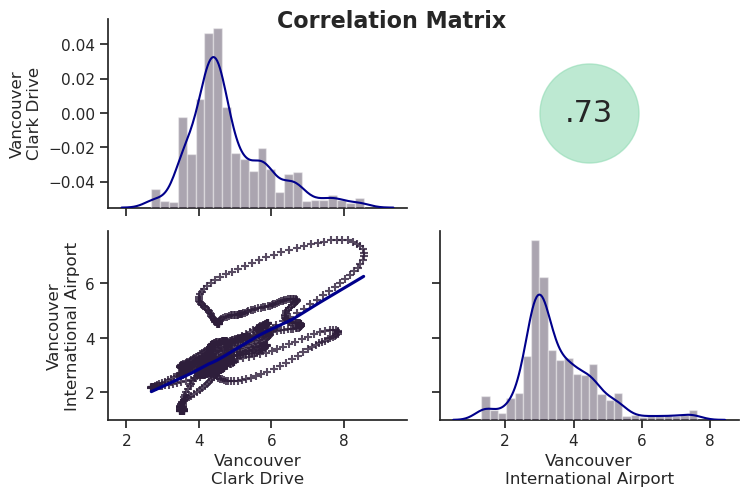

In [18]:
# Correlation between trends
from tshelpers.plot import plot_correlation

trends_df = pd.concat({
        "Vancouver\nClark Drive": decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"]["trend"],
        "Vancouver\nInternational Airport": decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"]["trend"]
    }, axis=1)

plot_correlation(trends_df, trends_df.columns)

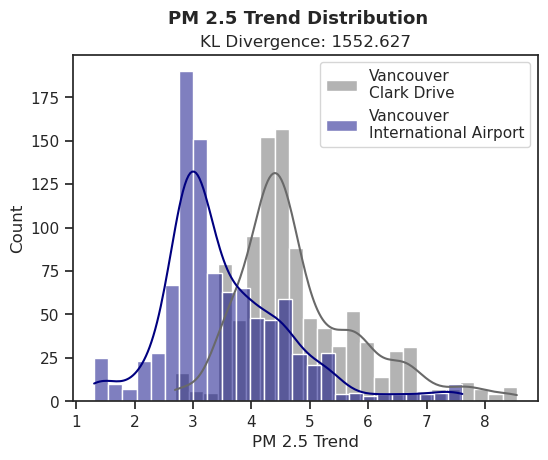

In [19]:
# KL Divergence
from scipy.special import rel_entr

KL_Div = sum(rel_entr(decompositions["Vancouver_Clark_Drive_PM25"]["Decomposition"]["trend"],
             decompositions["Vancouver_International_Airport_#2_PM25"]["Decomposition"]["trend"]))

plt.figure(figsize=(6, 4.5))
sns.histplot(trends_df, x="Vancouver\nClark Drive", label="Vancouver\nClark Drive", kde=True, color="dimgray")
sns.histplot(trends_df, x="Vancouver\nInternational Airport", label="Vancouver\nInternational Airport", kde=True, color="navy")
plt.suptitle(f"PM 2.5 Trend Distribution", fontsize=13, fontweight="bold")
plt.title(f"KL Divergence: {KL_Div:.3f}", fontsize=12)
plt.xlabel("PM 2.5 Trend")
plt.legend()
plt.show()